In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import ehr_ml.timeline
import ehr_ml.ontology
import ehr_ml.index
import ehr_ml.labeler
import ehr_ml.clmbr
from ehr_ml.clmbr import Trainer
from ehr_ml.clmbr import PatientTimelineDataset
from ehr_ml.clmbr.dataset import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')


<Figure size 432x288 with 0 Axes>

In [10]:
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr'
results_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/notebooks/figures'
extract_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/extracts/20210723'
cohort_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/cohort'
hparams_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/hyperparams'

data_path = f'/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/labelled_data/hospital_mortality/pretrained/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01'

bl_model_path = f'{model_path}/pretrained/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01'
cl_model_path = f'{model_path}/contrastive_learn/model/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/'

In [11]:
train_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_train.csv')
val_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_val.csv')
test_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_test.csv')

train_days = pd.read_csv(f'{data_path}/day_indices_train.csv')
val_days = pd.read_csv(f'{data_path}/day_indices_val.csv')
test_days = pd.read_csv(f'{data_path}/day_indices_test.csv')

train_labels = pd.read_csv(f'{data_path}/labels_train.csv')
val_labels = pd.read_csv(f'{data_path}/labels_val.csv')
test_labels = pd.read_csv(f'{data_path}/labels_test.csv')

train_data = (train_labels.to_numpy().flatten(),train_pids.to_numpy().flatten(),train_days.to_numpy().flatten())
val_data = (val_labels.to_numpy().flatten(),val_pids.to_numpy().flatten(),val_days.to_numpy().flatten())
test_data = (test_labels.to_numpy().flatten(),test_pids.to_numpy().flatten(),test_days.to_numpy().flatten())

dataset = PatientTimelineDataset( f'{extract_path}/extract.db', f'{extract_path}/ontology.db', f'{bl_model_path}/info.json', train_data, test_data )

In [12]:
cl_grid = list(
    ParameterGrid(
        yaml.load(
            open(
                f"{os.path.join('/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/best','hyperparams')}.yml",
                'r'
            ),
            Loader=yaml.FullLoader
        )
    )
)

In [13]:
cos_sims = []
cos_sim = nn.CosineSimilarity(dim=-1)
with torch.no_grad():
    with DataLoader(dataset, 9262, is_val=True, batch_size=2000, seed=44, device='cuda:0') as eval_loader:
        for j, batch in enumerate(eval_loader):
            bl_model = ehr_ml.clmbr.CLMBR.from_pretrained(bl_model_path, 'cuda:0')
            bl_outputs = bl_model(batch)['rnn']
            for cl_hp in cl_grid:
                sim = []
                for i in range(20):
                    cl_model_path = f"{model_path}/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_{cl_hp['batch_size']}_lr_{cl_hp['lr']}_temp_{cl_hp['temp']}_pool_{cl_hp['pool']}/{i}"
                    cl_model = ehr_ml.clmbr.CLMBR.from_pretrained(cl_model_path, 'cuda:0')
                    cl_outputs = cl_model(batch)['rnn']
                    sims = cos_sim(bl_outputs, cl_outputs)
                    sims = torch.mean(sims, 1)
                    sim.append(torch.mean(sims, 0).item())
                print(sim)
            cos_sims.append(sim)
            if j == 10:
                break
print(cos_sims)


[0.5987274050712585, 0.4766969084739685, 0.4124473035335541, 0.37897706031799316, 0.3626420497894287, 0.3452328145503998, 0.34478959441185, 0.35132306814193726, 0.34722933173179626, 0.3688892126083374, 0.36864274740219116, 0.3732885718345642, 0.3932667374610901, 0.3929617404937744, 0.39174312353134155, 0.3935853838920593, 0.39461517333984375, 0.39440828561782837, 0.3956504762172699, 0.39528530836105347]
[0.749082624912262, 0.6821308732032776, 0.634919285774231, 0.6006267070770264, 0.5780838131904602, 0.5635766983032227, 0.5634061098098755, 0.5661764144897461, 0.5649711489677429, 0.5735294818878174, 0.5732451677322388, 0.575183629989624, 0.587853193283081, 0.5876590013504028, 0.5871027708053589, 0.5871568322181702, 0.586023211479187, 0.5877986550331116, 0.587431788444519, 0.5875424742698669]
[0.6061565279960632, 0.47348687052726746, 0.40998902916908264, 0.37768682837486267, 0.36178407073020935, 0.3489660620689392, 0.35047245025634766, 0.3516446053981781, 0.3460353910923004, 0.3603470921

In [14]:
np_sims = np.array(cos_sims)
print(np.mean(np_sims,0))
mean_sims = np.mean(np_sims,0)

[0.66475357 0.54995602 0.4898056  0.45450081 0.43524827 0.4215292
 0.42072791 0.42582126 0.42203971 0.43499466 0.43447997 0.43769659
 0.45236473 0.45238012 0.45229647 0.45286526 0.45311821 0.45377642
 0.45433878 0.45492784]


In [15]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

<Figure size 432x288 with 0 Axes>

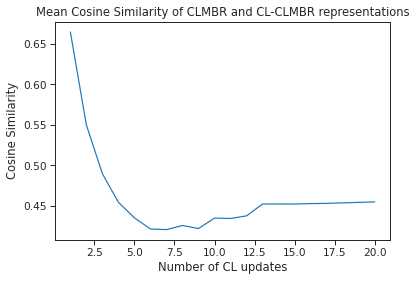

In [16]:
plt.plot([i+1 for i in range(20)],mean_sims)
plt.title('Mean Cosine Similarity of CLMBR and CL-CLMBR representations')
plt.xlabel('Number of CL updates')
plt.ylabel('Cosine Similarity')
plt.savefig('figures/similarity.png',bbox_inches='tight')
plt.show()